In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random 


import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as rf
import models.fcnn as fcnn

import data_utils.data_analysis as data_analysis

In [2]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [3]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [4]:
#time in fs (it is the boundary)
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [5]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [6]:
#write the data to a hdf5 file so no need to reconstruct it every time notebook is restarted

In [7]:
filename_pulse='datasets/pulse_240918.h5'

In [8]:
#read the data
df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop the shots with 'bad' goodness

In [9]:
df_input_reduced=df_input[df_input['goodness']>1.1]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [10]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,163182,34400.0,-23000.0,-4900000.0,1.428754
1,163185,34400.0,-23000.0,-4900000.0,1.443683
2,163186,34400.0,-23000.0,-4900000.0,1.103443
3,163188,34400.0,-23000.0,-4900000.0,1.418891
4,163189,34400.0,-23000.0,-4600000.0,1.335844
...,...,...,...,...,...
5349,172661,35400.0,28000.0,-4000000.0,1.244578
5350,172662,35400.0,28000.0,-4000000.0,1.225033
5351,172663,35400.0,28000.0,-4000000.0,1.205895
5352,172667,35400.0,28000.0,-4000000.0,1.199801


In [11]:
#split the dataset (X:dazzler param, Y:wizzler)
#all shots 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_pulse_200_reduced,rand_split=False)

# Build the model

In [12]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


### Train a forward model (RF) to compare

In [13]:
def train_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf#,df_error_forward_rf

In [14]:
%%time
forward_model_rf=train_forward(X_train, X_test, y_train, y_test)

CPU times: user 5.73 s, sys: 231 ms, total: 5.96 s
Wall time: 5.96 s


In [15]:
y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

### Train the CVAE

In [16]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
model=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    #hidden_dims_enc=[int(total_in*1.5),int(total_in*1.5),int(total_in),int(total_in/2),int(total_in/4)],
    #hidden_dims_dec=[int(total_in*1.5),int(total_in*1.5),total_in,int(total_in),int(total_in/3),out_dim]
)
batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
#summary(model,[(batch_size,y_length),(batch_size,x_length)])
summary(model,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 51]                  --
│    └─Sequential: 2-1                   [10, 244]                 --
│    │    └─Linear: 3-1                  [10, 244]                 50,020
│    │    └─LeakyReLU: 3-2               [10, 244]                 --
│    └─Sequential: 2-2                   [10, 204]                 --
│    │    └─Linear: 3-3                  [10, 204]                 49,980
│    │    └─LeakyReLU: 3-4               [10, 204]                 --
│    └─Sequential: 2-3                   [10, 102]                 --
│    │    └─Linear: 3-5                  [10, 102]                 20,910
│    │    └─LeakyReLU: 3-6               [10, 102]                 --
│    └─Sequential: 2-4                   [10, 51]                  --
│    │    └─Linear: 3-7                  [10, 51]                  5,253


In [17]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			model,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.4574662148952484
Finished epoch 20,latest loss 0.05123124271631241
Finished epoch 40,latest loss 0.03833719342947006
Finished epoch 60,latest loss 0.03236790746450424
Finished epoch 80,latest loss 0.029880736023187637
Finished epoch 100,latest loss 0.025871945545077324
Finished epoch 120,latest loss 0.027154093608260155
Finished epoch 140,latest loss 0.025222284719347954
Finished epoch 160,latest loss 0.023030797019600868
Finished epoch 180,latest loss 0.02650625817477703
Finished epoch 200,latest loss 0.02036299742758274
Finished epoch 220,latest loss 0.02073366567492485
Finished epoch 240,latest loss 0.019247310236096382
Finished epoch 260,latest loss 0.018077781423926353
Finished epoch 280,latest loss 0.017349572852253914
Finished epoch 299,latest loss 0.015808915719389915
Total time taken to train the model: 96.56s


Text(0.5, 0, 'Epoch')

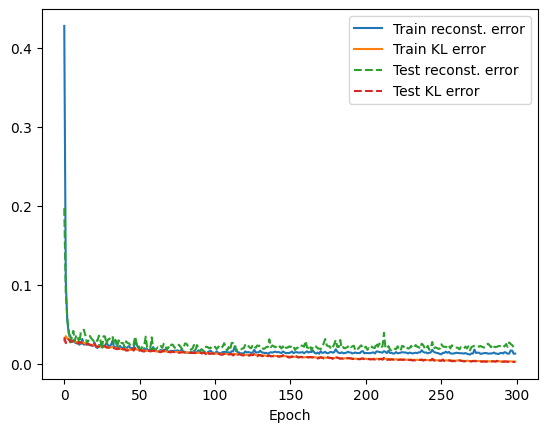

In [18]:
plt.plot(train_error[1],label='Train reconst. error')
plt.plot(train_error[2],label='Train KL error')
plt.plot(test_error[1],linestyle='--',label='Test reconst. error')
plt.plot(test_error[2],linestyle='--',label='Test KL error')
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

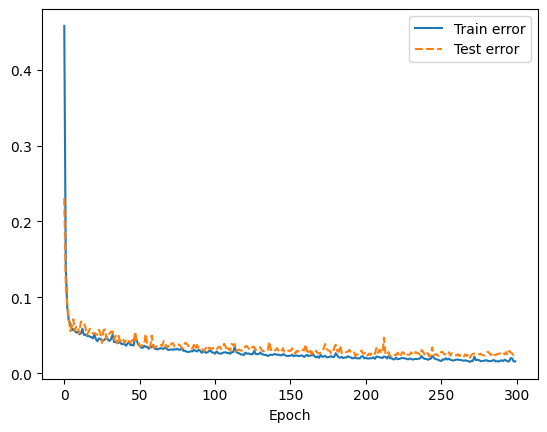

In [19]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

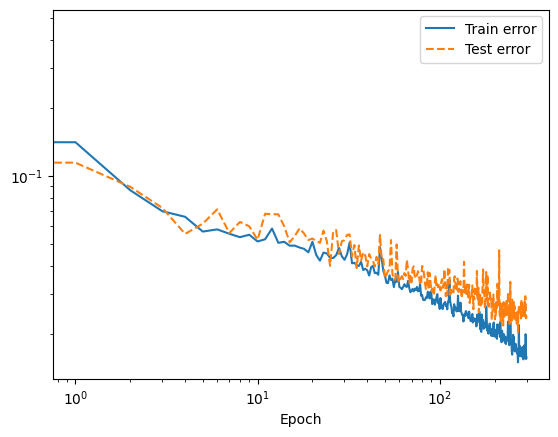

In [20]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

Known Dazzler values order2      34500.0
order3      25000.0
order4   -4900000.0
Name: 645, dtype: float64
[[   34593.64     23588.932 -4966805.   ]]


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


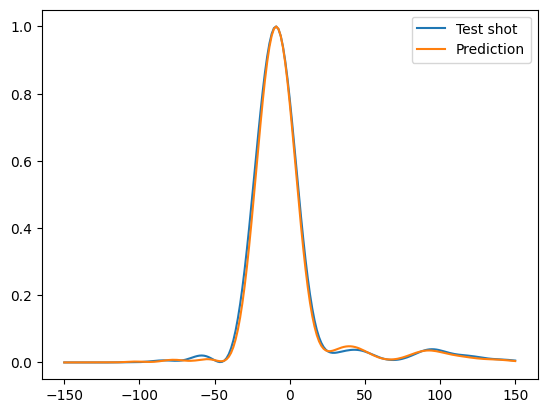

In [21]:
#Take a test pulse and Dazz, get the Dazz from CVAE
y_ex=y_test.iloc[50]
X_ex=X_test.iloc[50]
y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
X_ex_tensor=torch.tensor(X_ex.values,dtype=torch.float32)
X_ex_tensor=torch.reshape(X_ex_tensor,(1,3))
print('Known Dazzler values',X_ex)

dazz_norm=model_cvae.sample(1,y_ex_tensor,device).detach().cpu().numpy()
dazz_out=models_vae.renorm_data(dazz_norm,X_train)
print(dazz_out)

y_pred=rf.make_rf_prediction(forward_model_rf,dazz_out)

plt.plot(t_200,y_ex,label='Test shot')
plt.plot(t_200,y_pred[0],label='Prediction')
plt.legend()

In [22]:
#Take a test pulse and Dazz, get the Dazz from CVAE
index_shot=150
y_ex=y_test.iloc[index_shot]
X_ex=X_test.iloc[index_shot]
y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
X_ex_tensor=torch.tensor(X_ex.values,dtype=torch.float32)
X_ex_tensor=torch.reshape(X_ex_tensor,(1,3))
print('Known Dazzler values',X_ex)

#Build the distributions functions P(D|p*)
num_samples=10000
dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out=models_vae.renorm_data(dazz_norm,X_train)

dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

Known Dazzler values order2      34700.0
order3       4000.0
order4   -4600000.0
Name: 1341, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


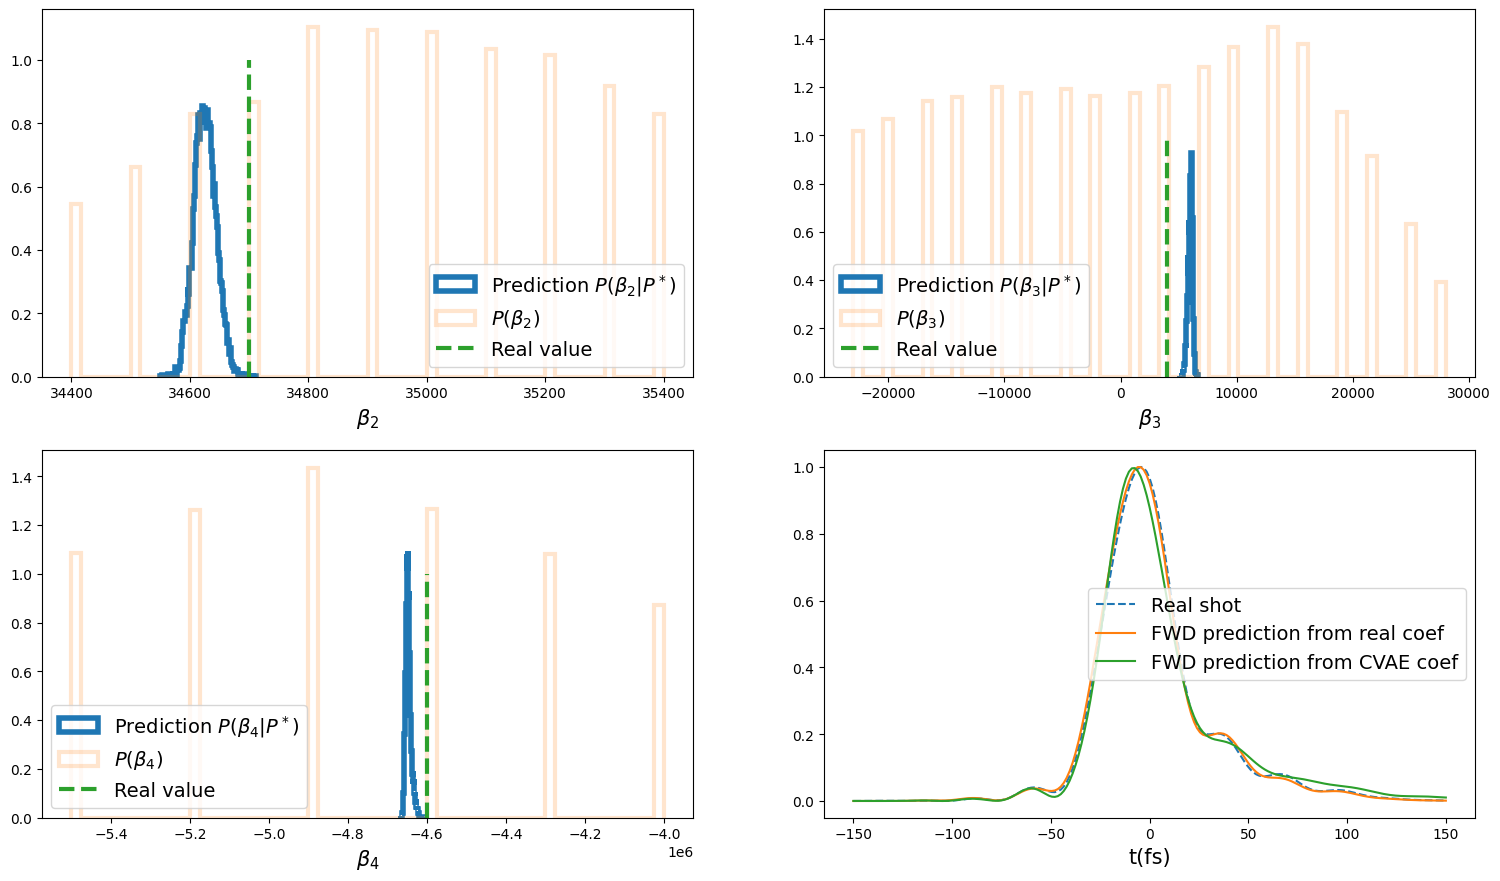

In [23]:
num_bins=100

y_order2=np.linspace(0,1,10)
x_order2=np.full_like(y_order2,X_ex['order2'])

y_order3=np.linspace(0,1,10)
x_order3=np.full_like(y_order3,X_ex['order3'])

y_order4=np.linspace(0,1,10)
x_order4=np.full_like(y_order4,X_ex['order4'])

weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
weights_input2 = 10*np.ones_like(df_input_reduced['order2']) / len(df_input_reduced['order2'])

weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
weights_input3 = 20*np.ones_like(df_input_reduced['order3']) / len(df_input_reduced['order3'])

weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
weights_input4 = 7*np.ones_like(df_input_reduced['order4']) / len(df_input_reduced['order4'])

plt.subplot(2, 2, 1)
plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$',linewidth=4)
plt.hist(df_input_reduced['order2'],bins=60,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.2,linewidth=3)
plt.plot(x_order2,y_order2,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_2$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 2)
plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$',linewidth=4)
plt.hist(df_input_reduced['order3'],bins=60,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.2,linewidth=3)
plt.plot(x_order3,y_order3,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_3$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 3)
plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$',linewidth=4)
plt.hist(df_input_reduced['order4'],bins=60,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.2,linewidth=3)
plt.plot(x_order4,y_order4,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_4$',size=15)
plt.legend(fontsize=14)

#prediction from the FWD with real parameters
y_pred_fwd_real=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([X_ex]))[0]

#predictions from teh generative model
max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

#print(o2_pred,o3_pred,o4_pred)
y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

plt.subplot(2, 2, 4)
plt.plot(t_200,y_ex,label='Real shot',linestyle='--')
plt.plot(t_200,y_pred_fwd_real,label='FWD prediction from real coef')
plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef')
plt.xlabel('t(fs)',size=15)
plt.legend(fontsize=14)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### Calculate error in the prediction

In [24]:
# The function gets the Y from a given shot. Predicts its X values. Then uses those X to reconstruct a pulse Y
#        using the forward model. Finally calculates the error from the predictiona dn real Y
#NOTE: X_train is the data that was used to normalized the X values
def get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device):
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex.values)))

    #Build the distributions functions P(D|p*)
    num_samples=10000
    #dazz_out_list=[]
    #for i in range(num_samples):
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)
        #dazz_out_list.append(dazz_out[0])
    #dazz_out_list=np.vstack(dazz_out_list)
    #P(D|p*) for each coefficient
    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    #get the highest prob value from those distr
    num_bins=100
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #Pass those predicted beta values to the forward model
    y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)],columns=['order2', 'order3', 'order4']))[0]
    #calculate the error (Mean Absolute Error)
    error=abs(y_ex-y_pred_fwd_cvae)
    error=error.sum()/len(error)
    return error

In [25]:
%%time
#num_test_shots=500
cvae_error=[]
for i in range(len(y_test)):
    #index_shot=random.randint(0,len(y_test))
    y_ex=y_test.iloc[i]
    error_pred_cvae=get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device)
    cvae_error.append(error_pred_cvae)
cvae_error=np.array(cvae_error)

CPU times: user 6min 16s, sys: 81 ms, total: 6min 16s
Wall time: 27 s


## Train roundtrip models (RF and NN) to compare

In [26]:
%%time
roundmodel_rf=rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)
mae_error_round=roundmodel_rf.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 2min 35s, sys: 221 ms, total: 2min 35s
Wall time: 2min 35s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [27]:
#round model NN
roundmodelNN=fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodelNN.train(300,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodelNN.predict(y_test)
error_round_model_nn=roundmodelNN.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.02811552584171295
Finished epoch 20,latest loss 0.0012464167084544897
Finished epoch 40,latest loss 0.0010894654551520944
Finished epoch 60,latest loss 0.0010250202612951398
Finished epoch 80,latest loss 0.0009674862376414239
Finished epoch 100,latest loss 0.0009067894425243139
Finished epoch 120,latest loss 0.0008607308845967054
Finished epoch 140,latest loss 0.0008203905890695751
Finished epoch 160,latest loss 0.0007963485550135374
Finished epoch 180,latest loss 0.000778429617639631
Finished epoch 200,latest loss 0.0007559102377854288
Finished epoch 220,latest loss 0.0007421340560540557
Finished epoch 240,latest loss 0.0007338518043980002
Finished epoch 260,latest loss 0.0007242824649438262
Finished epoch 280,latest loss 0.0007170969620347023
Finished epoch 299,latest loss 0.0007355056586675346
Total time taken to train the model: 86.62s
Training the backward model
Finished epoch 0,latest loss 1.01079523563385
Finished epoch 5

### Random guess model (using FWD RF)

In [28]:
## Random guess 'model'
o2min=X_test['order2'].min()
o2max=X_test['order2'].max()
o3min=X_test['order3'].min()
o3max=X_test['order3'].max()
o4min=X_test['order4'].min()
o4max=X_test['order4'].max()

o2_list=[]
o3_list=[]
o4_list=[]
for i in range(len(X_test)):
    o2_list.append(random.uniform(o2min,o2max))
    o3_list.append(random.uniform(o3min,o3max))
    o4_list.append(random.uniform(o4min,o4max))

X_test_rand=pd.DataFrame({'order2':o2_list,'order3':o3_list,'order4':o4_list})#,o3_list,o4_list])#,columns=['order2','order3','order4'])

#Pass those predicted (but random) beta values to the forward model
y_pred_fwd_rand=rf.make_rf_prediction(forward_model_rf,X_test_rand)
#calculate the error (Mean Absolute Error)
error_rand=abs(y_test-y_pred_fwd_rand)
error_rand=error_rand.sum(axis=1)/y_test.shape[1]

Text(0.5, 1.0, 'Model Accuracy (round trip)')

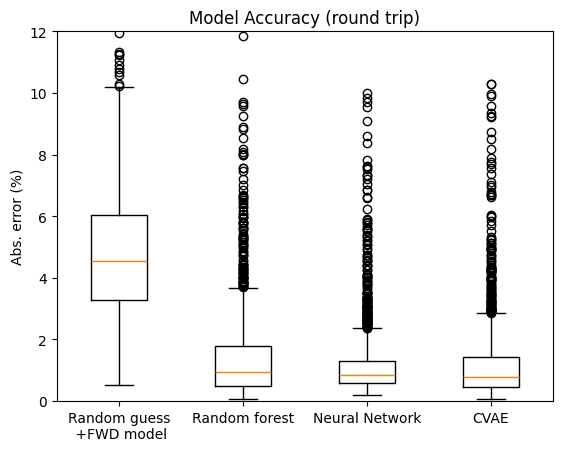

In [29]:
error_dist=[100*error_rand,
            100*mae_error_round,
            100*error_round_model_nn,
            100*cvae_error]
labels=['Random guess\n +FWD model','Random forest','Neural Network','CVAE']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,12)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (round trip)')

## Data size impact on CVAE

In [30]:
#np.random.seed(10)
def drop_shots(drop_factor,df_input_clean,df_time_clean):#,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input_clean)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input_clean.index, remove_n, replace=False)
    df_input_subset = df_input_clean.drop(drop_indices)
    df_time_subset = df_time_clean.drop(drop_indices)
    #df_freq_int_subset = df_freq_int_clean.drop(drop_indices)
    #print(df_input_subset)
    #print(df_time_subset)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [31]:
drop_factor=0.45
df_input_subset_3k,df_time_subset_3k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.80
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.945
df_input_subset_300,df_time_subset_300=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.98
df_input_subset_100,df_time_subset_100=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 2945
The datasize is no: 1071
The datasize is no: 295
The datasize is no: 108


### Create small datasets

In [32]:
def get_cvae_from_subset(t_200,df_input_subset,df_time_subset):
    X_train_subset, X_test_subset, y_train_subset, y_test_subset=models_tools.split_dataset_roundtrip(df_input_subset,df_time_subset,rand_split=False)
    
    #norm the X (Dazz parameters)
    #X_train_norm_subset=models_fcnn.norm_data(X_train_subset,X_train_subset)
    #X_test_norm_subset=models_fcnn.norm_data(X_test_subset,X_train_subset)

    #convert data to tensors (no need to normalize values for Y)
    #y_train_tensor_subset=torch.tensor(y_train_subset.values,dtype=torch.float32)
    #y_test_tensor_subset=torch.tensor(y_test_subset.values,dtype=torch.float32)

    #X_train_tensor_subset=torch.tensor(X_train_norm_subset.values,dtype=torch.float32)
    #X_test_tensor_subset=torch.tensor(X_test_norm_subset.values,dtype=torch.float32)

    #define the model
    total_in=len(t_200)+len(X_train_subset.columns) #number of input: pulse+Dazz
    out_dim=len(X_train_subset.columns)#dazz coefficients
    model_subset=models_vae.ConditionalVAE(
        in_pulse_features=len(t_200),
        num_param=out_dim,
        latent_dim=5,
        hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
        hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    )

    model_cvae_subset,train_error_subset,test_error_subset=models_vae.train_vae(y_train_subset,y_test_subset,X_train_subset,X_test_subset,
                model_subset,device,n_epochs=600,batch_size=1024,print_freq=50,learning_rate=0.001)

    #train a RF forward model
    print('Training the RF FWD mode')
    forward_model_rf_subset=train_forward(X_train_subset, X_test_subset, y_train_subset, y_test_subset)

    cvae_error_subset=[]
    for i in range(len(y_test_subset)):
        #index_shot=random.randint(0,len(y_test))
        y_ex=y_test_subset.iloc[i]
        error_pred_cvae=get_error_cvae(y_ex,model_cvae_subset,forward_model_rf_subset,X_train_subset,device)
        cvae_error_subset.append(error_pred_cvae)
    cvae_error_subset=np.array(cvae_error_subset)
    return cvae_error_subset, model_cvae_subset

In [33]:
cvae_error_3k, model_cvae_3k=get_cvae_from_subset(t_200,df_input_subset_3k,df_time_subset_3k)

Training on: cpu
Finished epoch 0,latest loss 1.401768684387207
Finished epoch 50,latest loss 0.3446865677833557
Finished epoch 100,latest loss 0.19827868044376373
Finished epoch 150,latest loss 0.14687107503414154
Finished epoch 200,latest loss 0.11769513785839081
Finished epoch 250,latest loss 0.10875806212425232
Finished epoch 300,latest loss 0.09120138734579086
Finished epoch 350,latest loss 0.0829705074429512
Finished epoch 400,latest loss 0.07323072850704193
Finished epoch 450,latest loss 0.06985347718000412
Finished epoch 500,latest loss 0.06135055422782898
Finished epoch 550,latest loss 0.06259382516145706
Finished epoch 599,latest loss 0.059072744101285934
Total time taken to train the model: 17.91s
Training the RF FWD mode


In [34]:
cvae_error_1k, model_cvae_1k=get_cvae_from_subset(t_200,df_input_subset_1k,df_time_subset_1k)

Training on: cpu
Finished epoch 0,latest loss 1.3934376239776611
Finished epoch 50,latest loss 0.7213577032089233
Finished epoch 100,latest loss 0.3566819131374359
Finished epoch 150,latest loss 0.24874866008758545
Finished epoch 200,latest loss 0.19892117381095886
Finished epoch 250,latest loss 0.16110660135746002
Finished epoch 300,latest loss 0.1388782262802124
Finished epoch 350,latest loss 0.12078336626291275
Finished epoch 400,latest loss 0.1070830225944519
Finished epoch 450,latest loss 0.09565010666847229
Finished epoch 500,latest loss 0.08740472048521042
Finished epoch 550,latest loss 0.08150874078273773
Finished epoch 599,latest loss 0.07522518932819366
Total time taken to train the model: 5.15s
Training the RF FWD mode


In [35]:
cvae_error_300, model_cvae_300=get_cvae_from_subset(t_200,df_input_subset_300,df_time_subset_300)

Training on: cpu
Finished epoch 0,latest loss 5.732863903045654
Finished epoch 50,latest loss 3.244814157485962
Finished epoch 100,latest loss 1.829840898513794
Finished epoch 150,latest loss 1.1371238231658936
Finished epoch 200,latest loss 0.689967930316925
Finished epoch 250,latest loss 0.5269764065742493
Finished epoch 300,latest loss 0.43870237469673157
Finished epoch 350,latest loss 0.34238895773887634
Finished epoch 400,latest loss 0.29621028900146484
Finished epoch 450,latest loss 0.22728918492794037
Finished epoch 500,latest loss 0.18560190498828888
Finished epoch 550,latest loss 0.15634207427501678
Finished epoch 599,latest loss 0.136631578207016
Total time taken to train the model: 3.37s
Training the RF FWD mode


In [36]:
cvae_error_100, model_cvae_100=get_cvae_from_subset(t_200,df_input_subset_100,df_time_subset_100)

Training on: cpu
Finished epoch 0,latest loss 16.758129119873047
Finished epoch 50,latest loss 8.15595817565918
Finished epoch 100,latest loss 5.411875247955322
Finished epoch 150,latest loss 3.781639814376831
Finished epoch 200,latest loss 2.694800853729248
Finished epoch 250,latest loss 2.027378797531128
Finished epoch 300,latest loss 1.5457072257995605
Finished epoch 350,latest loss 1.0699501037597656
Finished epoch 400,latest loss 0.9737818241119385
Finished epoch 450,latest loss 0.6461318731307983
Finished epoch 500,latest loss 0.5099535584449768
Finished epoch 550,latest loss 0.4681392312049866
Finished epoch 599,latest loss 0.45216360688209534
Total time taken to train the model: 2.94s
Training the RF FWD mode


Text(0.5, 1.0, 'CVAE error (mae)')

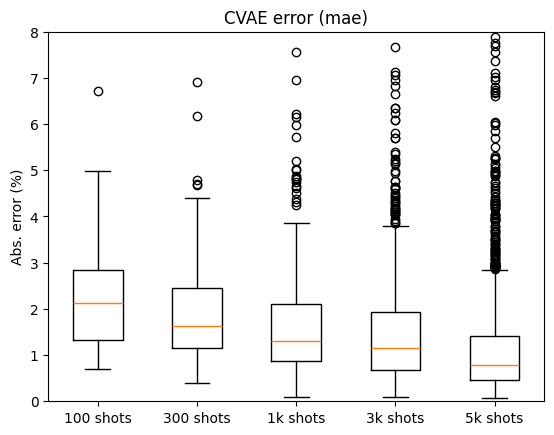

In [37]:
error_dist=[100*cvae_error_100,
            100*cvae_error_300,
            100*cvae_error_1k,
            100*cvae_error_3k,
            100*cvae_error]
labels=['100 shots','300 shots','1k shots','3k shots','5k shots',]
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,8)
plt.ylabel('Abs. error (%)')
plt.title('CVAE error (mae)')

In [38]:
#Take a test pulse and Dazz, get the Dazz from CVAE
index_shot=150
y_ex=y_test.iloc[index_shot]
X_ex=X_test.iloc[index_shot]
y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
X_ex_tensor=torch.tensor(X_ex.values,dtype=torch.float32)
X_ex_tensor=torch.reshape(X_ex_tensor,(1,3))
print('Known Dazzler values',X_ex)

#Build the distributions functions P(D|p*)
#from the big model (large dataset)
num_samples=10000
dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out=models_vae.renorm_data(dazz_norm,X_train)

dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

#and from a small one
#num_samples=10000
dazz_norm_1k=model_cvae_1k.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out_1k=models_vae.renorm_data(dazz_norm_1k,X_train)

dist_order2_1k=dazz_out_1k[:,0]#dazz_out_list[:,0]
dist_order3_1k=dazz_out_1k[:,1]#dazz_out_list[:,1]
dist_order4_1k=dazz_out_1k[:,2]#dazz_out_list[:,2]

Known Dazzler values order2      34700.0
order3       4000.0
order4   -4600000.0
Name: 1341, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


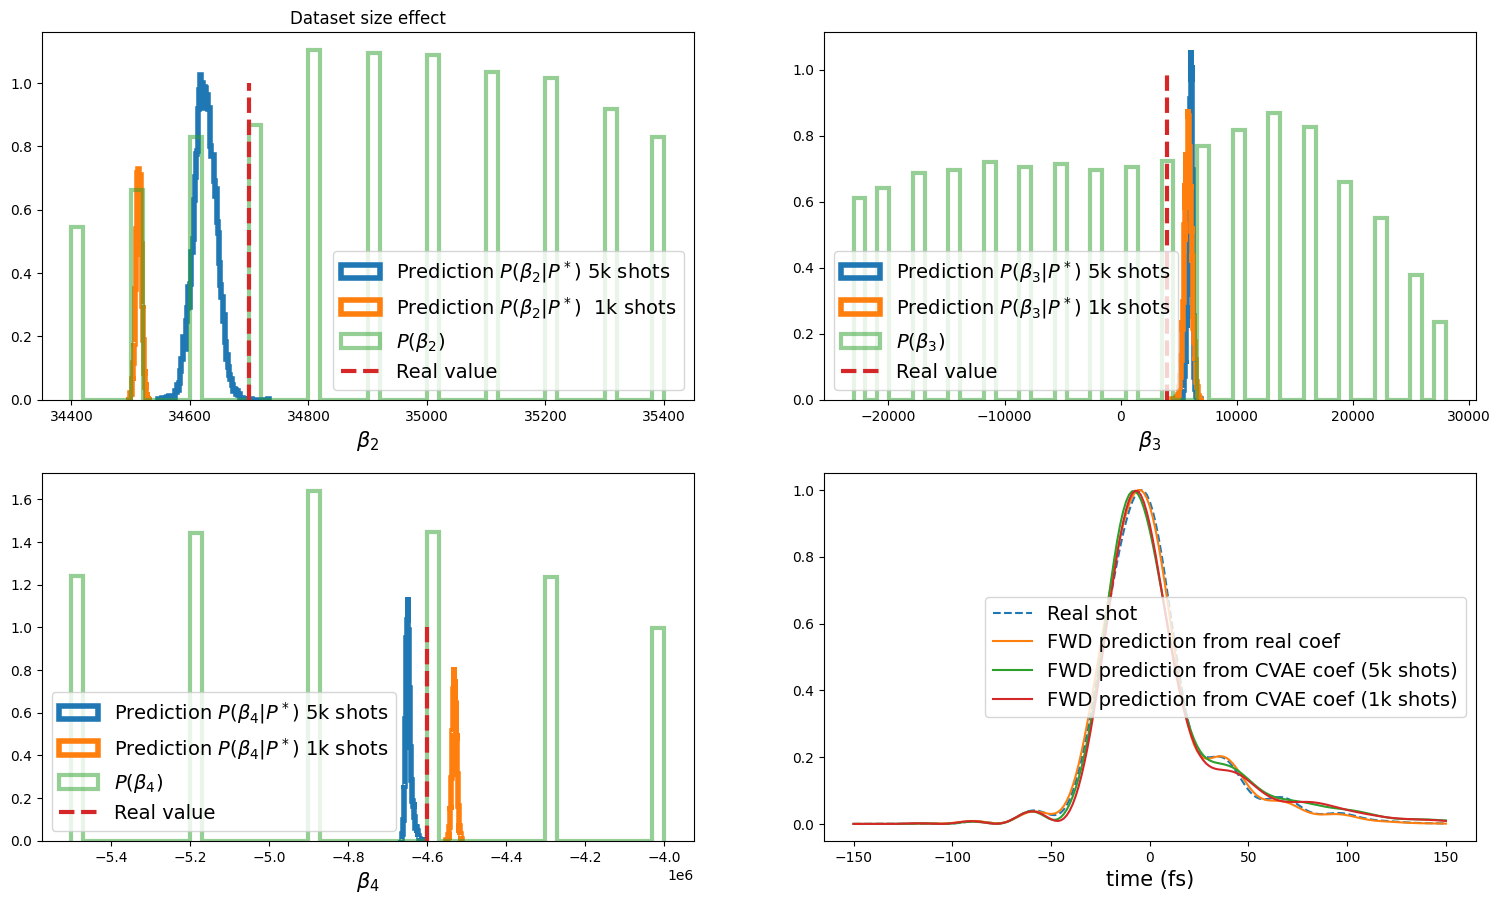

In [39]:
num_bins=100

y_order2=np.linspace(0,1,10)
x_order2=np.full_like(y_order2,X_ex['order2'])

y_order3=np.linspace(0,1,10)
x_order3=np.full_like(y_order3,X_ex['order3'])

y_order4=np.linspace(0,1,10)
x_order4=np.full_like(y_order4,X_ex['order4'])

weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
weights_input2 = 10*np.ones_like(df_input_reduced['order2']) / len(df_input_reduced['order2'])

weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
weights_input3 = 12*np.ones_like(df_input_reduced['order3']) / len(df_input_reduced['order3'])

weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
weights_input4 = 8*np.ones_like(df_input_reduced['order4']) / len(df_input_reduced['order4'])

plt.subplot(2, 2, 1)
plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$ 5k shots',linewidth=4)
plt.hist(dist_order2_1k,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$  1k shots',linewidth=4)
plt.hist(df_input_reduced['order2'],bins=50,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3)
plt.plot(x_order2,y_order2,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_2$',size=15)
plt.legend(fontsize=14)
plt.title('Dataset size effect')

plt.subplot(2, 2, 2)
plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$ 5k shots',linewidth=4)
plt.hist(dist_order3_1k,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$ 1k shots',linewidth=4)
plt.hist(df_input_reduced['order3'],bins=50,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.5,linewidth=3)
plt.plot(x_order3,y_order3,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_3$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 3)
plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$ 5k shots',linewidth=4)
plt.hist(dist_order4_1k,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$ 1k shots',linewidth=4)
plt.hist(df_input_reduced['order4'],bins=50,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3)
plt.plot(x_order4,y_order4,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_4$',size=15)
plt.legend(fontsize=14)

#prediction from the FWD with real parameters
y_pred_fwd_real=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([X_ex]))[0]

#predictions from teh generative model
max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]


#for the small dataset
max_prob_o2_ind_1k=np.argmax(np.histogram(dist_order2_1k,bins=num_bins)[0]) #index of the maximum value in the P
o2_pred_1k=np.histogram(dist_order2_1k,bins=num_bins)[1][max_prob_o2_ind_1k]

max_prob_o3_ind_1k=np.argmax(np.histogram(dist_order3_1k,bins=num_bins)[0]) #index of the maximum value in the P
o3_pred_1k=np.histogram(dist_order3_1k,bins=num_bins)[1][max_prob_o3_ind_1k]

max_prob_o4_ind_1k=np.argmax(np.histogram(dist_order4_1k,bins=num_bins)[0]) #index of the maximum value in the P
o4_pred_1k=np.histogram(dist_order4_1k,bins=num_bins)[1][max_prob_o4_ind_1k]


#print(o2_pred,o3_pred,o4_pred)
y_pred_fwd_cvae_5k=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]
y_pred_fwd_cvae_1k=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred_1k,o3_pred_1k,o4_pred_1k)]))[0]

plt.subplot(2, 2, 4)
plt.plot(t_200,y_ex,label='Real shot',linestyle='--')
plt.plot(t_200,y_pred_fwd_real,label='FWD prediction from real coef')
plt.plot(t_200,y_pred_fwd_cvae_5k,label='FWD prediction from CVAE coef (5k shots)')
plt.plot(t_200,y_pred_fwd_cvae_1k,label='FWD prediction from CVAE coef (1k shots)')
plt.xlabel('time (fs)',size=15)
plt.legend(fontsize=14)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## Deeper network

In [40]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
model_deep=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in*2),int(total_in*3),int(total_in*2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),int(total_in*2),int(total_in*3),int(total_in*2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    #hidden_dims_enc=[int(total_in*1.5),int(total_in*1.5),int(total_in),int(total_in/2),int(total_in/4)],
    #hidden_dims_dec=[int(total_in*1.5),int(total_in*1.5),total_in,int(total_in),int(total_in/3),out_dim]
)

batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
#summary(model,[(batch_size,y_length),(batch_size,x_length)])
summary(model_deep,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 51]                  --
│    └─Sequential: 2-1                   [10, 244]                 --
│    │    └─Linear: 3-1                  [10, 244]                 50,020
│    │    └─LeakyReLU: 3-2               [10, 244]                 --
│    └─Sequential: 2-2                   [10, 408]                 --
│    │    └─Linear: 3-3                  [10, 408]                 99,960
│    │    └─LeakyReLU: 3-4               [10, 408]                 --
│    └─Sequential: 2-3                   [10, 612]                 --
│    │    └─Linear: 3-5                  [10, 612]                 250,308
│    │    └─LeakyReLU: 3-6               [10, 612]                 --
│    └─Sequential: 2-4                   [10, 408]                 --
│    │    └─Linear: 3-7                  [10, 408]                 250,1

In [42]:
model_cvae_deep,train_error_deep,test_error_deep=models_vae.train_vae(y_train,y_test,X_train,X_test,
			model_deep,device,n_epochs=400,batch_size=32,print_freq=50,learning_rate=0.001)

Training on: cpu
Finished epoch 0,latest loss 0.7490615248680115
Finished epoch 50,latest loss 0.030811939388513565
Finished epoch 100,latest loss 0.025983424857258797
Finished epoch 150,latest loss 0.017407702282071114
Finished epoch 200,latest loss 0.011327422223985195
Finished epoch 250,latest loss 0.0139893414452672
Finished epoch 300,latest loss 0.01096087135374546
Finished epoch 350,latest loss 0.006822298746556044
Finished epoch 399,latest loss 0.0042237285524606705
Total time taken to train the model: 337.56s


Text(0.5, 0, 'Epoch')

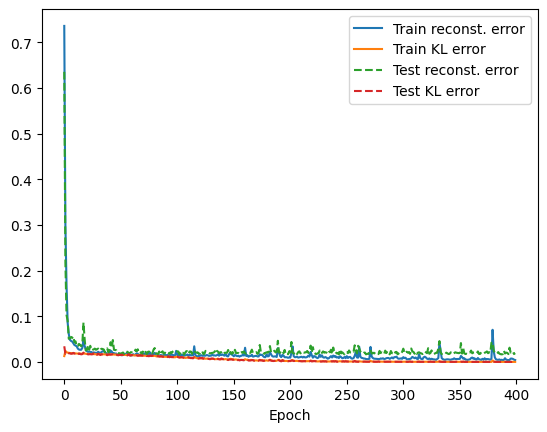

In [43]:
plt.plot(train_error_deep[1],label='Train reconst. error')
plt.plot(train_error_deep[2],label='Train KL error')
plt.plot(test_error_deep[1],linestyle='--',label='Test reconst. error')
plt.plot(test_error_deep[2],linestyle='--',label='Test KL error')
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

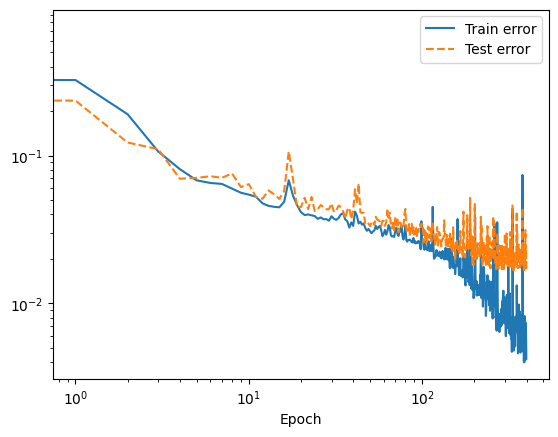

In [44]:
plt.plot(train_error_deep[0],label='Train error')
plt.plot(test_error_deep[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

Known Dazzler values order2      34700.0
order3       4000.0
order4   -4600000.0
Name: 1341, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


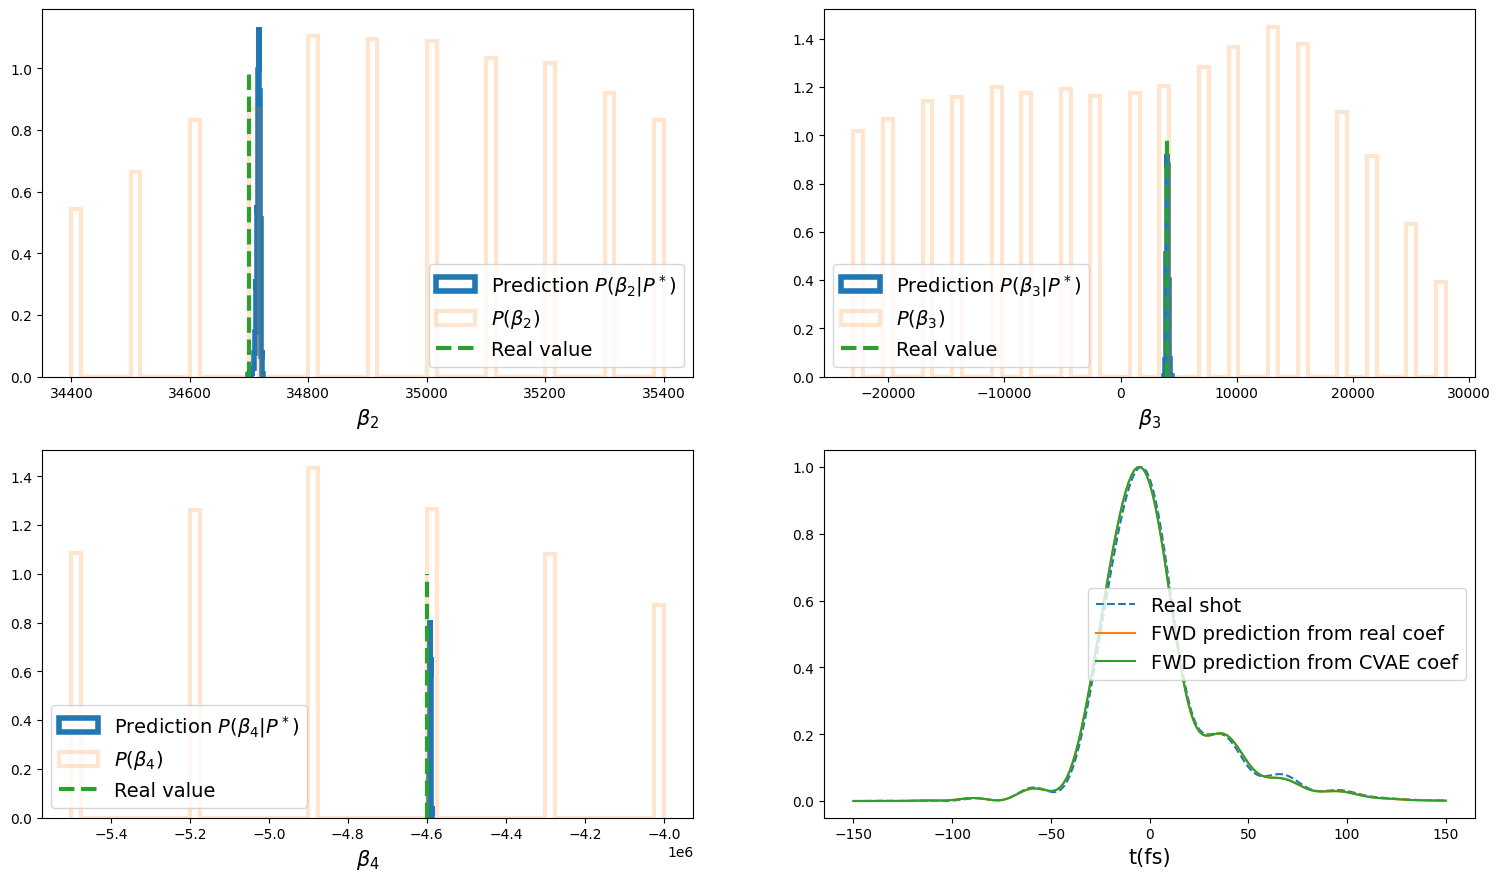

In [45]:
#Take a test pulse and Dazz, get the Dazz from CVAE
index_shot=150
y_ex=y_test.iloc[index_shot]
X_ex=X_test.iloc[index_shot]
y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
X_ex_tensor=torch.tensor(X_ex.values,dtype=torch.float32)
X_ex_tensor=torch.reshape(X_ex_tensor,(1,3))
print('Known Dazzler values',X_ex)

#Build the distributions functions P(D|p*)
num_samples=10000
dazz_norm=model_cvae_deep.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out=models_vae.renorm_data(dazz_norm,X_train)

dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

num_bins=100

y_order2=np.linspace(0,1,10)
x_order2=np.full_like(y_order2,X_ex['order2'])

y_order3=np.linspace(0,1,10)
x_order3=np.full_like(y_order3,X_ex['order3'])

y_order4=np.linspace(0,1,10)
x_order4=np.full_like(y_order4,X_ex['order4'])

weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
weights_input2 = 10*np.ones_like(df_input_reduced['order2']) / len(df_input_reduced['order2'])

weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
weights_input3 = 20*np.ones_like(df_input_reduced['order3']) / len(df_input_reduced['order3'])

weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
weights_input4 = 7*np.ones_like(df_input_reduced['order4']) / len(df_input_reduced['order4'])

plt.subplot(2, 2, 1)
plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$',linewidth=4)
plt.hist(df_input_reduced['order2'],bins=60,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.2,linewidth=3)
plt.plot(x_order2,y_order2,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_2$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 2)
plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$',linewidth=4)
plt.hist(df_input_reduced['order3'],bins=60,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.2,linewidth=3)
plt.plot(x_order3,y_order3,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_3$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 3)
plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$',linewidth=4)
plt.hist(df_input_reduced['order4'],bins=60,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.2,linewidth=3)
plt.plot(x_order4,y_order4,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_4$',size=15)
plt.legend(fontsize=14)

#prediction from the FWD with real parameters
y_pred_fwd_real=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([X_ex]))[0]

#predictions from teh generative model
max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

#print(o2_pred,o3_pred,o4_pred)
y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

plt.subplot(2, 2, 4)
plt.plot(t_200,y_ex,label='Real shot',linestyle='--')
plt.plot(t_200,y_pred_fwd_real,label='FWD prediction from real coef')
plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef')
plt.xlabel('t(fs)',size=15)
plt.legend(fontsize=14)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [46]:
%%time
#num_test_shots=500
cvae_error_deep=[]
for i in range(len(y_test)):
    #index_shot=random.randint(0,len(y_test))
    y_ex=y_test.iloc[i]
    error_pred_cvae=get_error_cvae(y_ex,model_cvae_deep,forward_model_rf,X_train,device)
    cvae_error_deep.append(error_pred_cvae)
cvae_error_deep=np.array(cvae_error_deep)

CPU times: user 18min 35s, sys: 356 ms, total: 18min 35s
Wall time: 1min 21s


Text(0.5, 1.0, 'Model Accuracy (round trip)')

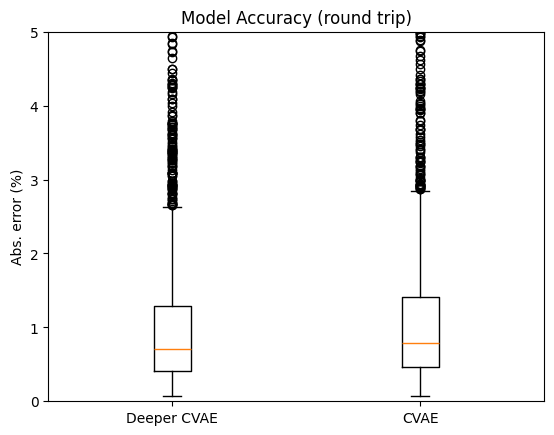

In [47]:
error_dist=[100*cvae_error_deep,
            100*cvae_error]
labels=['Deeper CVAE','CVAE']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,5)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (round trip)')